In [115]:
#Librairies
#!pip install xlrd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.interpolate import LSQUnivariateSpline
from scipy.optimize import curve_fit
from functools import partial

In [116]:
#diseable warnings
import warnings
warnings.filterwarnings('ignore')

In [117]:
#Data
#Excel file must be in same folder as python code
#Excel file from Harvard Business School case study "Deutsche Bank: Finding Relative-Value Trades"
df = pd.read_excel(
    'XLS698-XLS-ENG-2.xls', 
    sheet_name='Exhibit 1',
    usecols="A:C",         
    skiprows=2,            
    nrows=52
    )

In [118]:
#copy of original dataframe
df_original = df.copy()

In [119]:
df

,Coupon Rate (%),Maturity Date,Current Price
0,3.000,2/15/2004,101.0544
1,2.125,8/15/2004,100.9254
2,1.500,2/15/2005,99.8942
3,6.500,8/15/2005,109.0934
4,5.625,2/15/2006,108.4380
5,2.375,8/15/2006,99.7848
6,6.250,2/15/2007,111.7184
7,3.250,8/15/2007,101.0841
8,3.000,2/15/2008,99.1692
9,3.250,8/15/2008,99.2710


In **df**, we have market prices for a set of coupon-paying bonds quoted on August 15, 2003.  
Each bond is characterized by its semi-annual coupon rate, its maturity date, and its current market price.

# BOOTSTRAPPING

In this section, using market prices of coupon-paying bonds, we will first extract discount bond levels for each maturity. Then, with these levels, we can compute the corresponding yields.

we assume that each bond's cash flow is fixed and known. Additionally, we assume that all bonds are similar in terms of their liquidity (no worries about an illiquidity premium), quality and tax treatment.

In [120]:
#converting from % to float and changing data format
df['Coupon Rate'] = df['Coupon Rate (%)'] / 100  
df['Maturity Date'] = pd.to_datetime(df['Maturity Date'])

#adding time to maturity and periods(semi-annual coupons)
start_date = datetime(2003, 8, 15)
df['Time to Maturity (Years)'] = ((df['Maturity Date'] - start_date).dt.days / 365.25).round(1).astype(float)
df['Periods'] = (df['Time to Maturity (Years)'] * 2).astype(int)

df.head()

,Coupon Rate (%),Maturity Date,Current Price,Coupon Rate,Time to Maturity (Years),Periods
0,3.000,2004-02-15,101.0544,0.03000,0.5,1
1,2.125,2004-08-15,100.9254,0.02125,1.0,2
2,1.500,2005-02-15,99.8942,0.01500,1.5,3
3,6.500,2005-08-15,109.0934,0.06500,2.0,4
4,5.625,2006-02-15,108.4380,0.05625,2.5,5


**COMPUTING DISCOUNT BONDS**

In [121]:
#Bulding a list of discount bonds
discount_bonds = []

for index, row in df.iterrows():
    cashflows = []
    coupon_rate = row['Coupon Rate'] / 2
    periods = row['Periods']
    bond_price = row['Current Price']

    cashflows =  [coupon_rate] * periods
    cashflows[-1] += 1

    if periods == 1:
        disc_fac = bond_price / cashflows[0]
        #print(cashflows)
            
    else:
        sum_previous_cashflows = sum([cashflows[i] * discount_bonds[i] for i in range(len(discount_bonds))])
        #print('sum previous cash and bond price and last cash', sum_previous_cashflows, bond_price, cashflows[-1])
        disc_fac = (bond_price - sum_previous_cashflows) / cashflows[-1]

    discount_bonds.append(disc_fac)
   
#Discount bonds ino df 
df['Discount Bonds (%)'] = discount_bonds

In [122]:
df.head()

,Coupon Rate (%),Maturity Date,Current Price,Coupon Rate,Time to Maturity (Years),Periods,Discount Bonds (%)
0,3.000,2004-02-15,101.0544,0.03000,0.5,1,99.560985
1,2.125,2004-08-15,100.9254,0.02125,1.0,2,98.817627
2,1.500,2005-02-15,99.8942,0.01500,1.5,3,97.673807
3,6.500,2005-08-15,109.0934,0.06500,2.0,4,96.340626
4,5.625,2006-02-15,108.4380,0.05625,2.5,5,94.737455


**COMPUTING YIELDS**

When calculating yields, it is important to be mindful of the compounding frequency used, as it significantly affects the results.
Here, we are following the market bond equivalent yield (BEY) convention. This approach makes sense because, later, we will compare our results with Deutsche Bank's model yields, which are also quoted using this convention.

In [123]:
#Building bond equivalent yields
zerocoupon_yields = [0] * len(discount_bonds)
for index, row in df.iterrows():
    time_to_maturity = row['Time to Maturity (Years)']
    bond_price = row['Discount Bonds (%)']
    term1 = -(1/(2*time_to_maturity))
    term2 = (bond_price/100)**term1
    zerocoupon_yields[index] = 2*(term2-1) 
    
df['Market Zero Coupon Yields'] = zerocoupon_yields

In [124]:
df.head()

,Coupon Rate (%),Maturity Date,Current Price,Coupon Rate,Time to Maturity (Years),Periods,Discount Bonds (%),Market Zero Coupon Yields
0,3.000,2004-02-15,101.0544,0.03000,0.5,1,99.560985,0.008819
1,2.125,2004-08-15,100.9254,0.02125,1.0,2,98.817627,0.011930
2,1.500,2005-02-15,99.8942,0.01500,1.5,3,97.673807,0.015753
3,6.500,2005-08-15,109.0934,0.06500,2.0,4,96.340626,0.018727
4,5.625,2006-02-15,108.4380,0.05625,2.5,5,94.737455,0.021742


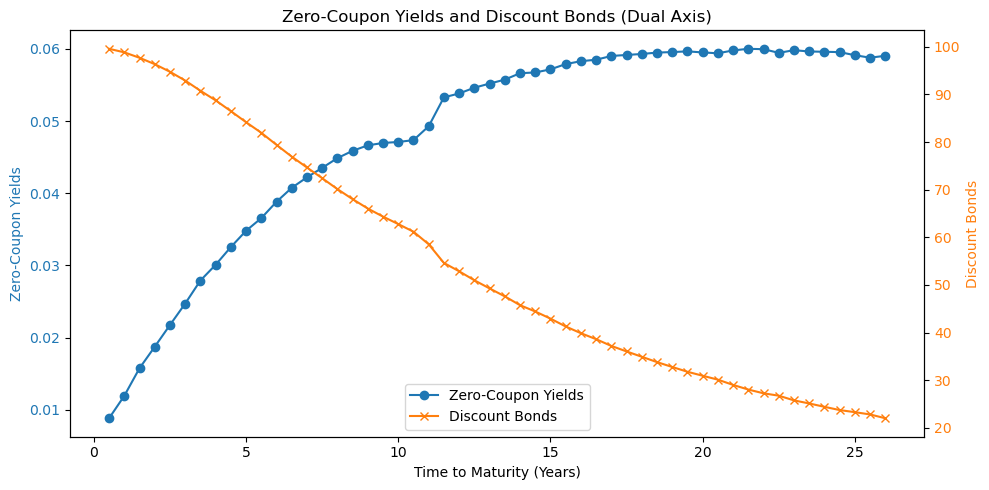

In [125]:
#Plotting yields and discount bonds
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel("Time to Maturity (Years)")
ax1.set_ylabel("Zero-Coupon Yields", color='tab:blue')
line1 = ax1.plot(df['Time to Maturity (Years)'], zerocoupon_yields, label='Zero-Coupon Yields', marker='o', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel("Discount Bonds", color='tab:orange')
line2 = ax2.plot(df['Time to Maturity (Years)'], discount_bonds, label='Discount Bonds', marker='x', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='lower center')

plt.title("Zero-Coupon Yields and Discount Bonds (Dual Axis)")
fig.tight_layout()  
plt.show()

**STRATEGY BASE ON DB MODEL**

We also have access to Deutsche Bank's proprietary yield curve model for a set of maturities. We will compare the levels from their model with market levels to identify any arbitrage opportunities.

In [126]:
#getting DB Yields from excel file
db_df = pd.read_excel(
    'XLS698-XLS-ENG-2.xls', 
    sheet_name='Exhibit 4 ',
    usecols="A:B",         
    skiprows=2,            
    nrows=13
    )  

In [127]:
#changing format and adding periods
db_df['Numerical Maturity'] = [int(ele[:-1]) for ele in db_df['Maturity (years)']]
db_df['Model Prediction (BEY)'] = [float(ele[:-1])/100 for ele in db_df['Model Prediction (BEY)']]
db_df['Periods'] = db_df['Numerical Maturity'] * 2

In [128]:
db_df

,Maturity (years),Model Prediction (BEY),Numerical Maturity,Periods
0,1y,0.012443,1,2
1,2y,0.018727,2,4
2,3y,0.024110,3,6
3,4y,0.029665,4,8
4,5y,0.034454,5,10
5,6y,0.038557,6,12
6,7y,0.041996,7,14
7,8y,0.044677,8,16
8,9y,0.046528,9,18
9,10y,0.047107,10,20


Above, we can see the different yield levels and the corresponding maturities. For the set of maturities at hand, let's compare the market levels with Deutsche Bank's model levels.

In [129]:
#comparaison dataframe
df_tocompare = df[df['Periods'].isin(db_df['Periods'].values)]
df_tocompare['DB Yields'] = db_df['Model Prediction (BEY)'].values

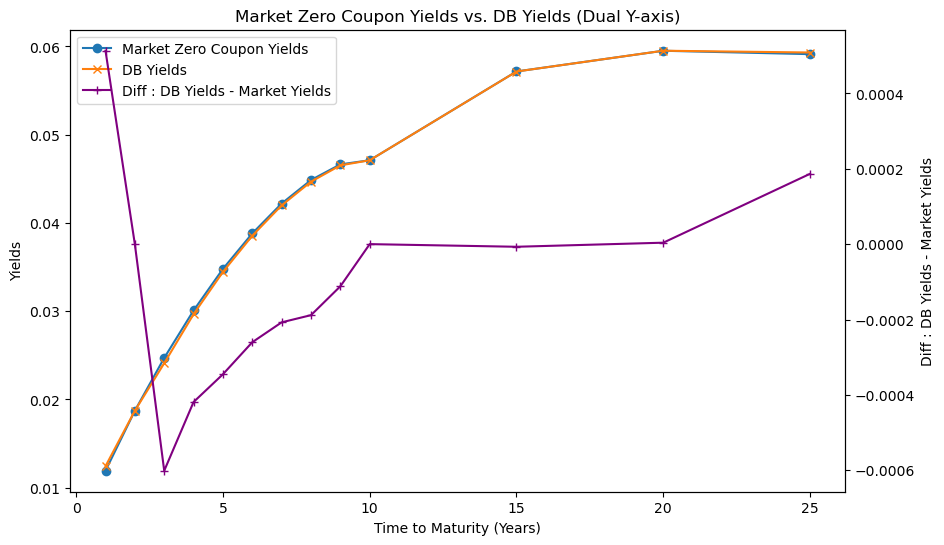

In [169]:
# Plotting price differences
fig, ax1 = plt.subplots(figsize=(10, 6))

# First y-axis (left)
line1, = ax1.plot(df_tocompare['Time to Maturity (Years)'], df_tocompare['Market Zero Coupon Yields'], 
                  label='Market Zero Coupon Yields', marker='o')
line2, = ax1.plot(df_tocompare['Time to Maturity (Years)'], df_tocompare['DB Yields'], 
                  label='DB Yields', marker='x')

ax1.set_xlabel("Time to Maturity (Years)")
ax1.set_ylabel("Yields")
ax1.set_title("Market Zero Coupon Yields vs. DB Yields (Dual Y-axis)")

# Second y-axis (right)
ax2 = ax1.twinx()
line3, = ax2.plot(df_tocompare['Time to Maturity (Years)'], 
                  df_tocompare['DB Yields'] - df_tocompare['Market Zero Coupon Yields'], 
                  label='Diff : DB Yields - Market Yields', color='purple', marker='+')
ax2.set_ylabel("Diff : DB Yields - Market Yields")

# Combine legends
lines = [line1, line2, line3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="best")

plt.show()

We can see that the market yield levels and those of Deutsche Bank's model align quite closely. However, they do not coincide perfectly. If one trusts Deutsche Bank's model, some mispricings can be exploited.   
Specifically, a strategy could involve buying a bond when the model predicts a lower zero-coupon yield than the zero-coupon yield observed in the market. In this case, if the model yield is lower, it indicates that the bond is undervalued in the market (since a higher yield implies a lower bond price), creating a buying opportunity. Conversely, the strategy would be to sell bonds when the model predicts a higher zero-coupon yield than the market yield. A higher yield suggests a lower bond price, creating an opportunity to sell at a higher value relative to the model’s pricing.

In [131]:
#result in a table
df_tocompare['DB - Market'] = df_tocompare['DB Yields'] - df_tocompare['Market Zero Coupon Yields']
sell_or_buy = df_tocompare['DB - Market']>0
sell_or_buy = ['SELL' if boolean==True else 'BUY' for boolean in sell_or_buy ]
df_tocompare['Buy or Sell'] = sell_or_buy

print('Buying or Selling Recap :')
df_tocompare

Buying or Selling Recap :


,Coupon Rate (%),Maturity Date,Current Price,Coupon Rate,Time to Maturity (Years),Periods,Discount Bonds (%),Market Zero Coupon Yields,DB Yields,DB - Market,Buy or Sell
1,2.125,2004-08-15,100.9254,0.02125,1.0,2,98.817627,0.011930,0.012443,5.133781e-04,SELL
3,6.500,2005-08-15,109.0934,0.06500,2.0,4,96.340626,0.018727,0.018727,-1.766456e-07,BUY
5,2.375,2006-08-15,99.7848,0.02375,3.0,6,92.896974,0.024711,0.024110,-6.011193e-04,BUY
7,3.250,2007-08-15,101.0841,0.03250,4.0,8,88.741808,0.030084,0.029665,-4.187825e-04,BUY
9,3.250,2008-08-15,99.2710,0.03250,5.0,10,84.155889,0.034799,0.034454,-3.451365e-04,BUY
11,6.000,2009-08-15,112.1450,0.06000,6.0,12,79.400038,0.038817,0.038557,-2.601106e-04,BUY
13,5.750,2010-08-15,110.3894,0.05750,7.0,14,74.650741,0.042203,0.041996,-2.073624e-04,BUY
15,5.000,2011-08-15,104.7607,0.05000,8.0,16,70.120440,0.044865,0.044677,-1.883032e-04,BUY
17,4.375,2012-08-15,99.2806,0.04375,9.0,18,66.038132,0.046640,0.046528,-1.117126e-04,BUY
19,4.250,2013-08-15,97.7693,0.04250,10.0,20,62.775437,0.047107,0.047107,1.643433e-07,SELL


**Arbitrage opportinuity?**  
Previously, I spoke of arbitrage opportinuity. But can this strategy really be caracterised as such? The answer is **NO**.
Indeed, we obtain the Zero-Coupon Yields (with the bootstrapping method) directly
from the market, so the discount function we obtain first is arbitrage-free (fully consistent with
market price). The price differences only reflect the use of a theoretical method
used by DB to price bonds. The model makes certain assumptions and simplifications. In
reality, things do not necessarily behave as assumed. The risk here is that the model might be
wrong. From that only, we can conclude that this is not a risk-free arbitrage strategy.

# CUBIC SPLINES INTERPOLATION

After deriving a yield curve from the bootstrapped zero-coupon bond prices, we are left with a
discrete curve. We will now generate a continuous discount function based on our discrete
yields curve using the Cubic Splines interpolation technique.

The cubic spline interpolation method creates a smooth curve by connecting several cubic
polynomials at specific points, known as "knot points." Each section of the curve, between two
consecutive knot points, is represented by its own cubic polynomial. These polynomials are
carefully "spliced" together to ensure a seamless transition at each knot point. To achieve this, the values and slopes (first and second derivatives) of the polynomials are matched at every knot point, resulting in a continuous and smooth curve that accurately fits the data across all
intervals.

Mathematically : 

![Description of the image](cubic_splines_maths.png)

**CUBIC SPLINES WITH 5 KNOTS**

We will use the following knots: 2, 5,10, 15 and 20-year.   

 Choosing 2, 5, 10, 15, and 20-year
maturities as knots for cubic spline interpolation on a yield curve with 52 data points (from 6
months to 26 years) is effective because these points capture key segments of the yield curve
across short, medium, and long maturities. These knots reflect common benchmarks in financial
markets, allowing for a smooth yet flexible curve that aligns with natural market trends without
overfitting. This choice balances accuracy and stability, enabling the spline to represent yield
movements realistically without introducing unnecessary complexity.

We use the function LSQUnivariateSpline from scipy.interpolate. This function is particularly convenient as it allows you to specify the exact knots of interest, in addition to the data points in the dataset. This flexibility lets you control the degree of freedom, making it better suited to specific situations. Other functions, like CubicSpline from scipy.interpolate, do not offer this option and treat all data points as knots. While this approach is useful with a limited number of data points, it may feel too rigid in some cases.

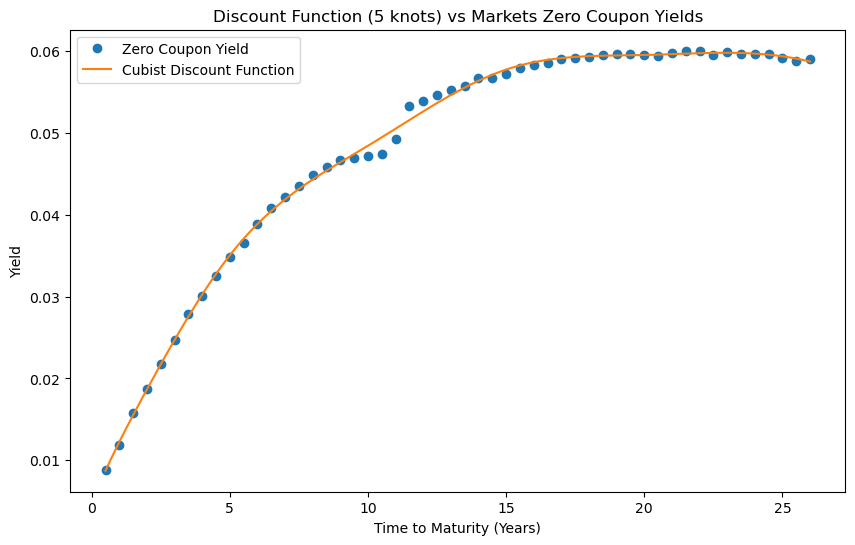

In [168]:
#implemention the interpolation
knots = [2, 5, 10, 15, 20]
x = df['Time to Maturity (Years)']
y = df['Market Zero Coupon Yields']
spline = LSQUnivariateSpline(x, y, t=knots)

x_inter = np.linspace(x.min(), x.max(), 500)
y_inter = spline(x_inter)

plt.figure(figsize=(10, 6))
#plt.plot(x, y, 'o', label='Zero Coupon Yield')
plt.plot(x, y, 'o', label='Zero Coupon Yield')
plt.plot(x_inter, y_inter, label='Cubist Discount Function')
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Yield")
plt.title("Discount Function (5 knots) vs Markets Zero Coupon Yields")
plt.legend()
plt.show()

This is how you can go from a discrete yield curve to generate a continuous one. This raises the question of when it is useful to go through this process.

Whether it is appropriate to use a continuous or discrete yield curve depends on the intended application. The bootstrapped yield curve is discrete, so if we are interested in maturities not available on the market, we are left without estimates. Cubic Spline interpolation is useful in this case, as it allows us to generate a continuous and smooth yield curve.

A discrete curve is appropriate when exact data points are critical, such as when assessing individual bond yields at specific times or unique events without interpolated estimates.

In contrast, a smooth continuous interpolation is suitable when a holistic view or estimation of intermediate values is needed. Smooth curves are valuable for visualizing trends, calculating derivatives, or modeling in areas where continuity reflects natural or expected transitions, as in yield curve construction or interest rate modeling across maturities.

When can see that points are not perfectly aligned, especially in maturity 10Y. Should we decide to use interpolated yields to decide which bond to buy or not, the result will effectivelly differs from using boostrapped yields. As discussed previously, as here we are making analysis on discret maturity and we do not need any intermediary date, it is better to use the discret yields curve.

**CUBIC SPLINE WITH 2 KNOTS**

We will now look at the interpolation when using only 2 knots, 5 and 20 years, and compare it
to our previous interpolation with 5 knots.

In [133]:
#Cubic Splines
#with 2 knots
knots_2 = []
spline_2knots = LSQUnivariateSpline(x, y, t=knots_2)
y_inter_2knots = spline_2knots(x_inter)

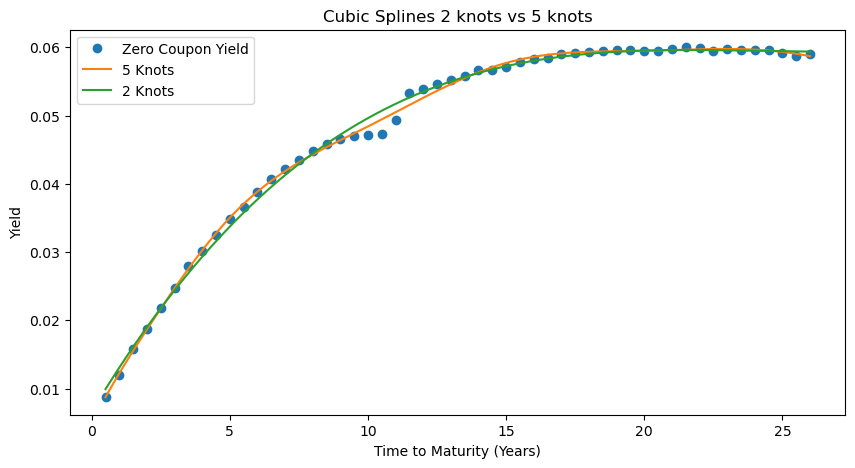

In [134]:
#plotting
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'o', label='Zero Coupon Yield')
plt.plot(x_inter, y_inter, label='5 Knots')
plt.plot(x_inter, y_inter_2knots, label='2 Knots')
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Yield")
plt.title("Cubic Splines 2 knots vs 5 knots")
plt.legend()
plt.show()

Using fewer knots, in this case, 2 instead of 5, has two main effects:  
• **Increased Smoothness**: Fewer knot points result in a smoother, more generalized curve
that may overlook finer details.  
• **Reduced Flexibility**: The curve becomes less responsive to local variations, potentially
missing smaller yield changes.



   

# NELSON SIEGEL SVENSSON MODEL

Let's now explore an alternative approach to generating a continuous yield curve from a set of discrete yield levels. We will model the curve using the Nelson-Siegel Svensson model, which does not merely interpolate between points but rather constructs a function combining different terms to capture the full behavior of the yield curve.

The NSS model captures the overall shape of the yield curve by combining multiple terms, each
influencing different segments of the curve. The NSS model function, therefore, represents
yields at various maturities T by combining these terms as follows:

![Description of the image](nelson.png)

**CALIBRATING NELSON SIEGEL SVENSSON**

The parameters 𝛽0, 𝛽1, 𝛽2, 𝛽3, 𝜃 and 𝜐 were optimized to minimize the Root Mean Square
Error (RMSE) between the NSS model yields and observed market yields. After optimization, the best-fit parameters
were applied to the NSS function.


The choice of the initial parameters 𝛽0=0.05, 𝛽1=0.02, 𝛽2=-0.03, 𝛽3=0.01, 𝜃 =10, 𝜐 =10 is to
provide a starting structure for the yield curve that aligns with our graphical observations.

In [135]:
#Nelson Siegel svensson spot rate function
def nelson_siegel_svensson(T, beta0, beta1, beta2, beta3, theta, nu):
    
    term1 = beta0
    term2 = beta1 * (1 - np.exp(-T / theta)) / (T / theta)
    term3 = beta2 * ((1 - np.exp(-T / theta)) / (T / theta) - np.exp(-T / theta))
    term4 = beta3 * ((1 - np.exp(-T / nu)) / (T / nu) - np.exp(-T / nu))
    
    return term1 + term2 + term3 + term4

In [136]:
#Fitting model
maturities = df['Time to Maturity (Years)']
yields = df['Market Zero Coupon Yields']
initial_guess = [0.05, 0.02, -0.03, 0.01, 10, 10]  #[beta0, beta1, beta2, beta3, theta, nu]

In [137]:
#Getting params
params, _ = curve_fit(nelson_siegel_svensson, maturities, yields, p0=initial_guess, maxfev=8000)
beta0, beta1, beta2, beta3, theta, nu = params

In [138]:
print('beta 0 :', params[0])
print('beta 1 :', params[1])
print('beta 2 :', params[2])
print('beta 3 :', params[3])
print('theta :', params[4])
print('nu :', params[5])

beta 0 : -0.1398078192842595
beta 1 : 0.14349073488706468
beta 2 : 0.08822170406646276
beta 3 : 0.5493013883962401
theta : 4.060631666909051
nu : 16.943900226347374


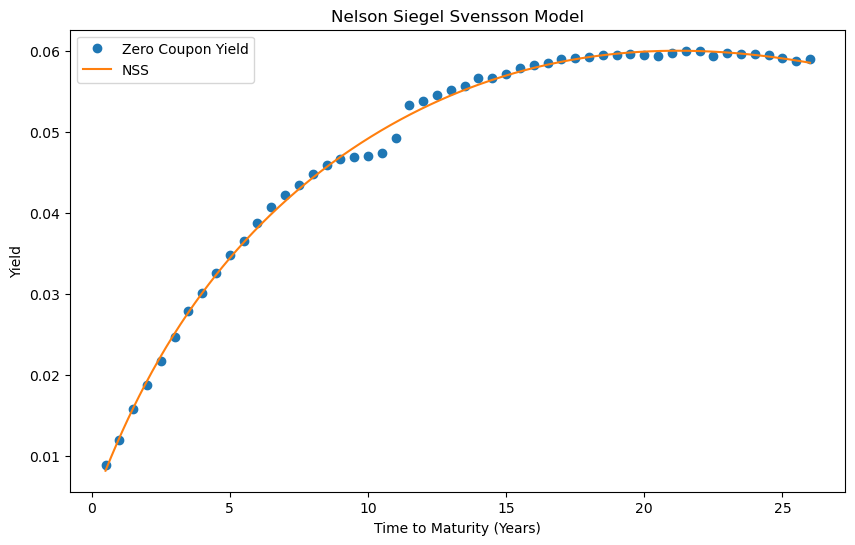

In [139]:
#Applying fitted function
partial_nelson_siegel_svensson = partial(nelson_siegel_svensson, beta0=beta0, beta1=beta1, beta2=beta2, beta3=beta3, theta=theta, nu=nu)

x_inter_NSS = np.linspace(maturities.min(), maturities.max(), 500)
NSS_yields = map(partial_nelson_siegel_svensson, x_inter)
NSS_yields = list(NSS_yields)

#Plot
plt.figure(figsize=(10, 6))
plt.plot(maturities, yields, 'o', label='Zero Coupon Yield')
plt.plot(x_inter_NSS, list(NSS_yields), label='NSS')
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Yield")
plt.title("Nelson Siegel Svensson Model")
plt.legend()
plt.show()

When fitting a parametric model to a set of data points, it is very important to choose your initial guesses wisely, as they can greatly impact the final result. Quick ways of getting good initial guesses include:

- **Plot the Data**: Look at the shape of your data and make rough guesses for parameters based on observed trends.

- **Use Statistics**: Calculate values like the average, maximum, or minimum to help estimate starting values.

- **Start Simple**: Fit an easier model (like a line) to establish a baseline for more complex models.

- **Use a Parameter Range**: Try different values for parameters within a broad range, then choose the one that fits best.

- **Global Search**: Use an optimization tool like differential_evolution to automatically search a wide range of values for a good starting point.

- **Set Bounds**: Limit parameter values to realistic ranges to help guide the fit.

In our case, we made a rough guess for initial parameters and are satisfied with the final fit.

In [140]:
#result table
NSS_yields_for_maturities = map(partial_nelson_siegel_svensson, df['Time to Maturity (Years)'])
NSS_yields_for_maturities = list(NSS_yields_for_maturities)
df['NSS Modeled Yield (%)'] = np.array(NSS_yields_for_maturities)*100

print('results table :')
df

results table :


,Coupon Rate (%),Maturity Date,Current Price,Coupon Rate,Time to Maturity (Years),Periods,Discount Bonds (%),Market Zero Coupon Yields,NSS Modeled Yield (%)
0,3.000,2004-02-15,101.0544,0.03000,0.5,1,99.560985,0.008819,0.815296
1,2.125,2004-08-15,100.9254,0.02125,1.0,2,98.817627,0.011930,1.219925
2,1.500,2005-02-15,99.8942,0.01500,1.5,3,97.673807,0.015753,1.587562
3,6.500,2005-08-15,109.0934,0.06500,2.0,4,96.340626,0.018727,1.922839
4,5.625,2006-02-15,108.4380,0.05625,2.5,5,94.737455,0.021742,2.229739
5,2.375,2006-08-15,99.7848,0.02375,3.0,6,92.896974,0.024711,2.511681
6,6.250,2007-02-15,111.7184,0.06250,3.5,7,90.756404,0.027905,2.771601
7,3.250,2007-08-15,101.0841,0.03250,4.0,8,88.741808,0.030084,3.012013
8,3.000,2008-02-15,99.1692,0.03000,4.5,9,86.479128,0.032544,3.235072
9,3.250,2008-08-15,99.2710,0.03250,5.0,10,84.155889,0.034799,3.442621


**COMPARING CUBIC SPLINES TO NELSON SIEGEL SVENSSON**

So far, we have used two different approaches to generate our continuous yield curve. It is interesting to examine the differences between the cubic spline interpolation and the Nelson-Siegel Svensson model.

Below, we will plot the different curves and discuss the results.

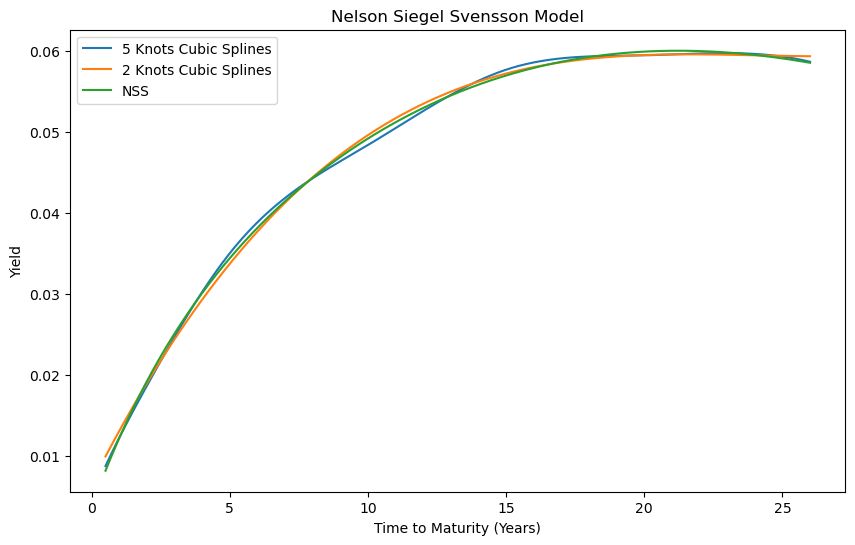

In [141]:
#Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_inter, y_inter, label='5 Knots Cubic Splines')
plt.plot(x_inter, y_inter_2knots, label='2 Knots Cubic Splines')
plt.plot(x_inter, list(NSS_yields), label='NSS')
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Yield")
plt.title("Nelson Siegel Svensson Model")
plt.legend()
plt.show()

In [142]:
#RMSE function
def get_rmse(y_fitted, y_real):
    rmse = np.sqrt(np.mean((y_real - y_fitted) ** 2))
    return rmse

#Getting y for table maturities
x = np.array(df['Time to Maturity (Years)'].values)
yields_real = np.array(df['Market Zero Coupon Yields'].values)

cubic_5knots = spline(x)
cubic_2knots = spline_2knots(x)
neslson = NSS_yields_for_maturities

#computing RMSE
rmse_cubic5 = get_rmse(cubic_5knots, yields_real)
rmse_cubic2 = get_rmse(cubic_2knots, yields_real)
rmse_neslson = get_rmse(neslson, yields_real)

In [143]:
print('RMSE for Cubic Splines with 5 knots :', rmse_cubic5)
print('RMSE for Cubic Splines with 2 knots :', rmse_cubic2)
print('RMSE for Nelson Siegel Model :', rmse_neslson)

RMSE for Cubic Splines with 5 knots : 0.0005681571246424888
RMSE for Cubic Splines with 2 knots : 0.0008744513014059967
RMSE for Nelson Siegel Model : 0.0007280884632753055


On the one hand, the NSS model appears to fit the general shape of the yield curve well,
especially in the short and long-maturity regions, although it deviates slightly in the mid-
maturity range. It offers a smoother and more stable curve. On the other hand, the cubic spline with 5 knots
provides a more accurate fit within the observed range and captures localized fluctuations more
closely than the NSS model. Effectively, the 5 knots cubic spline’s RMSE (0.000568) is significantly
lower than that of the NSS model (0.000728) thus confirming that the spline provides a more
precise fit.

TThat said, the results from cubic splines with two knots are very similar to those of the Nelson-Siegel model, providing a smoother but slightly less precise fit. This highlights the versatility of cubic splines, as adjusting the number and placement of knots allows you to achieve varied outcomes that may be better suited to specific applications.

In the Nelson-Siegel-Svensson (NSS) model, **loading factors** represent the weights assigned to different components of the model, each capturing specific characteristics of the yield curve. The primary loading factors are associated with level, slope, and curvature. Specifically, beta_0 represents the level (long-term rate), beta_1 determines the slope (short-term rate sensitivity), beta_2 captures the medium-term curvature, and beta_3 adds flexibility for additional curvature. Each factor adjusts the model’s sensitivity to changes at various points on the curve, allowing it to accurately represent yield dynamics over different maturities.

**Loading contributions** refer to the effect each loading factor has on the overall yield curve based on the maturity term. The NSS model uses decay parameters lambda_1 and lambda_2 to control the rate at which these factors’ impacts diminish over time. For example, beta_1 and beta_2 contribute heavily to short- and medium-term yields, respectively, but their influence wanes as maturity increases. By contrast, beta_0 maintains a constant contribution across all maturities. This layered contribution structure enables the model to capture the term structure’s changing shape as maturity varies.

**FACTOR LOADINGS**

In [144]:
#Factor loading
beta0_plot = [1] * len(x_inter_NSS)
beta1_plot = list(map( lambda T : (1 - np.exp(-T / theta)) / (T / theta), x_inter_NSS))
beta2_plot = list(map( lambda T : ((1 - np.exp(-T / theta)) / (T / theta) - np.exp(-T / theta)), x_inter_NSS))
beta3_plot = list(map( lambda T : ((1 - np.exp(-T / nu)) / (T / nu) - np.exp(-T / nu)), x_inter_NSS))

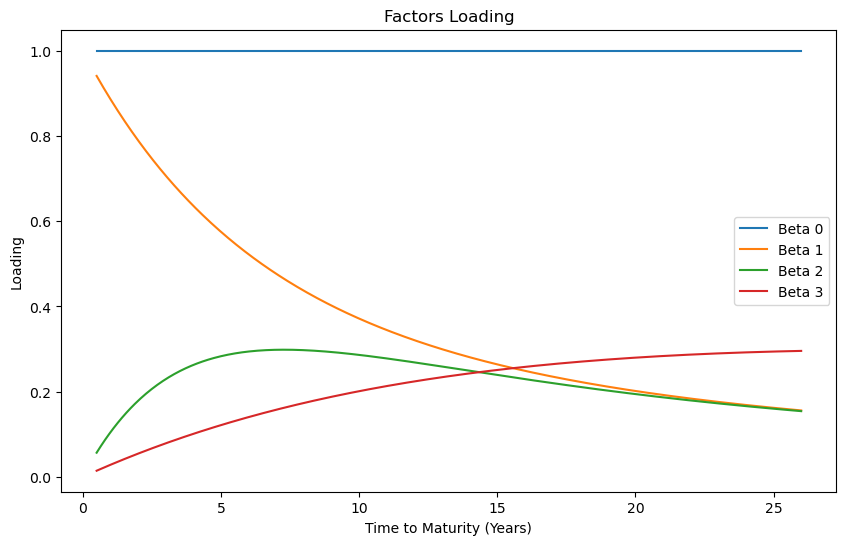

In [145]:
#Plot
plt.figure(figsize=(10, 6))
plt.plot(x_inter_NSS, beta0_plot, label='Beta 0')
plt.plot(x_inter_NSS, beta1_plot, label='Beta 1')
plt.plot(x_inter_NSS, beta2_plot, label='Beta 2')
plt.plot(x_inter_NSS, beta3_plot, label='Beta 3')
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Loading")
plt.title("Factors Loading")
plt.legend()
plt.show()

- **Beta 0 (Level)**: This is constant across all maturities, representing the long-term rate level. It provides a baseline level for the yield curve, as it affects all maturities equally.

- **Beta 1 (Slope)**: This component decreases sharply with maturity, meaning it has the highest impact on short-term rates but diminishes as time to maturity increases. This represents the slope of the yield curve, capturing the yield difference between short- and long-term bonds.

- **Beta 2 (Curvature)**: This factor initially increases, reaches a peak around mid-maturities, and then declines. It adds a hump-shaped contribution to the yield curve, influencing the medium-term rates the most and shaping the curvature of the curve.

- **Beta 3 (Additional Curvature)**: This component gradually increases and has a moderate impact on longer maturities. It provides extra flexibility for adjusting the curve’s shape, particularly in the longer term, which can be useful for capturing subtler changes in the curve's curvature at extended maturities.

**FACTOR CONTRIBUTIONS**

In [146]:
#factor contributions
beta0_cont = [beta0] * len(x_inter_NSS)
beta1_cont = list(map( lambda T : beta1 * ((1 - np.exp(-T / theta)) / (T / theta)), x_inter_NSS))
beta2_cont = list(map( lambda T : beta2 * (((1 - np.exp(-T / theta)) / (T / theta) - np.exp(-T / theta))), x_inter_NSS))
beta3_cont = list(map( lambda T : beta3 * (((1 - np.exp(-T / nu)) / (T / nu) - np.exp(-T / nu))), x_inter_NSS))

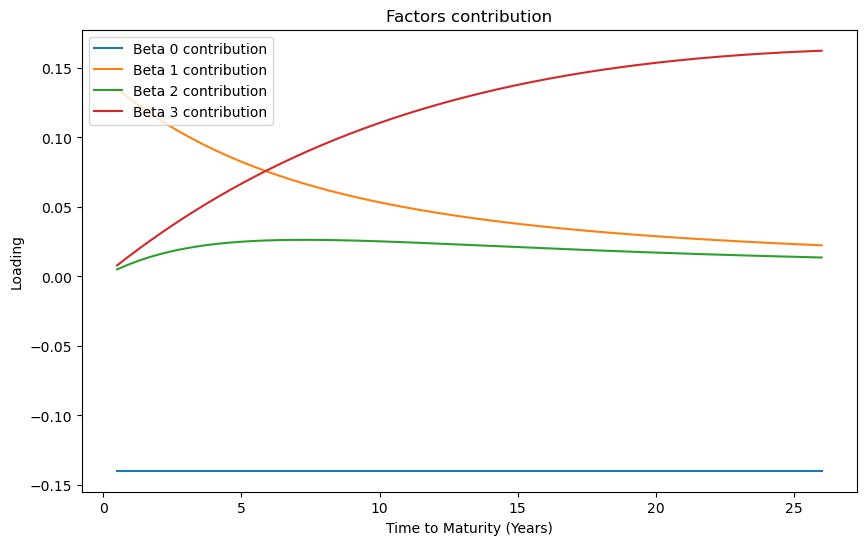

In [147]:
#Plot
plt.figure(figsize=(10, 6))
plt.plot(x_inter_NSS, beta0_cont, label='Beta 0 contribution')
plt.plot(x_inter_NSS, beta1_cont, label='Beta 1 contribution')
plt.plot(x_inter_NSS, beta2_cont, label='Beta 2 contribution')
plt.plot(x_inter_NSS, beta3_cont, label='Beta 3 contribution')
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Loading")
plt.title("Factors contribution")
plt.legend()
plt.show()


- **Beta 0 Contribution (Level)**: This is constant but negative across all maturities, providing a baseline that slightly lowers the overall yield curve. Its constant contribution reflects the long-term rate level but, in this case, adds a slight downward shift.

- **Beta 1 Contribution (Slope)**: This contribution starts high at short maturities and gradually decreases as maturity increases, emphasizing its role in shaping the curve’s slope. It has a diminishing effect over time, aligning with its purpose of capturing short-term rate sensitivity.

- **Beta 2 Contribution (Curvature)**: This factor has a modest, mostly stable positive contribution across mid-term maturities, adding a gentle curvature to the yield curve. Its peak influence occurs in the middle maturities, after which it slightly decreases, reflecting its function in capturing medium-term curvature.

- **Beta 3 Contribution (Additional Curvature)**: This factor gradually increases with maturity, providing the most significant positive contribution over the long term. It allows for additional flexibility to adjust the yield curve's shape, particularly in the later maturities, enhancing the model's ability to capture extended-term curvature features.

Given the shape of the initial yield curve, a negative Beta 0 is quite surprising, even though these parameters result in a relatively "good" fit overall. The RMSE is 0.00073, which is fairly high, and I suspect this is mainly due to the significant deviation around the 10-year maturity.

# HEDGING

Let’s explore a use case of a continuous yield curve in hedging. In hedging, a crucial metric is **key rate durations**, which measure a bond or portfolio’s sensitivity to interest rate changes at specific maturity points along the yield curve. Unlike assuming a parallel shift in interest rates across all maturities, key rate durations isolate the effect of rate changes at particular “key” maturities, such as 1 year, 5 years, or 10 years.

Each key rate duration indicates how much the bond’s price would change if the yield curve shifts only at that specific maturity, while yields at other maturities remain constant. This provides a more detailed view of interest rate risk, especially for portfolios with cash flows spread across various maturities, allowing hedgers to identify which parts of the yield curve most affect a bond or portfolio’s value.

In this context, having a continuous yield curve is essential. Analysis for key rate durations requires yield values across all maturities in one's book, not just those available on the market. A continuous yield curve fills these gaps, making it a valuable tool for precise risk management and hedging.

Different fitting techniques lead to different behaviors in the yield curve. In our case, while cubic splines provide a better fit, they are less resilient to yield curve shocks compared to the Nelson-Siegel-Svensson model. When shocking a specific maturity, the cubic spline interpolation causes unnatural movements across the entire curve. In contrast, the Nelson-Siegel-Svensson model produces a yield curve where shocks are more locally contained, resulting in a more natural behavior.

**SHOCKING 10Y MATURITY YIELD**

In [148]:
#Preparing dataframe
df_10YShocked = df.copy()

In [149]:
#Shocking by 50 bps
df_10YShocked.loc[df_10YShocked.Periods==20, 'Market Zero Coupon Yields'] += 0.005

In [150]:
#Cubic Splines Interpolation after shock
#Using 5 knots
knots = [2, 5, 10, 15, 20]
x_shocked = df_10YShocked['Time to Maturity (Years)']
y_shocked = df_10YShocked['Market Zero Coupon Yields']
spline_shocked = LSQUnivariateSpline(x_shocked, y_shocked, t=knots)

x_inter_shocked = np.linspace(x.min(), x.max(), 500)
y_inter_shocked = spline_shocked(x_inter_shocked)

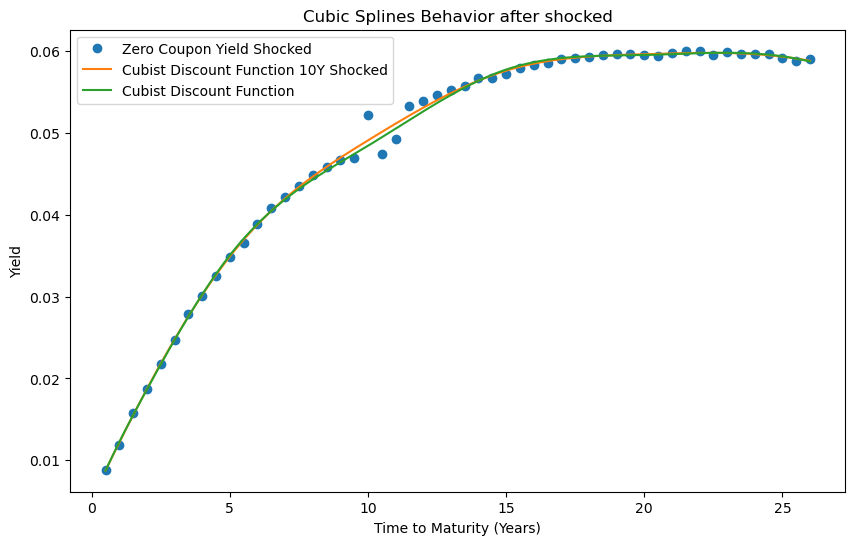

In [151]:
#Plotting shocked discret yields vs pre and post-shock interpolation
plt.figure(figsize=(10, 6))
#plt.plot(x, y, 'o', label='Zero Coupon Yield Non Shocked')
plt.plot(x, y_shocked, 'o', label='Zero Coupon Yield Shocked')
plt.plot(x_inter_shocked, y_inter_shocked, label='Cubist Discount Function 10Y Shocked')
plt.plot(x_inter, y_inter, label='Cubist Discount Function')
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Yield")
plt.title("Cubic Splines Behavior after shocked")
plt.legend()
plt.show()

We can see how shocking the 10-year yield affects the cubic spline fitting. In our case, the impact appears to be fairly well-contained, although there is some deviation at maturities much further from the 10-year point on the new cubic spline curve.

**10Y KEY RATE DURATION**

Key rate durations are a concept associated with a portfolio. Most often, assessing a portfolio’s KRD involves determining how much the portfolio’s value would change when the yield at a specific maturity is shocked by a given amount.

In this exercise, we will consider an equally weighted portfolio valued at $1 million, composed of all the bonds available in our market.

In [152]:
#Computing discount bonds from shocked yields curve
'''For simplicity and convenience, we will use the discrete shocked yield curve. 
   The correct methodology would involve re-estimating each yield level from the fitted curve after applying a shock. 
   However, using the discrete yield curve here still allows us to explore the concept of key rate durations (KRD).
'''
shocked_bondPrices = np.array(df_10YShocked['Discount Bonds (%)'])/100
shocked_bondPrices[19] = 1 / (1 + df_10YShocked.loc[19, "Market Zero Coupon Yields"] / 2) ** (2 * df_10YShocked.loc[19, "Time to Maturity (Years)"])
df_10YShocked['Shocked Discount Bonds'] = shocked_bondPrices

In [159]:
# Computing new coupon paying bond prices
def shocked_bonds_price(df_shocked):

    shocked_couponbonds = []
    discount_bonds = []
    
    for index, row in df_shocked.iterrows():
        coupon_rate = row['Coupon Rate'] / 2
        periods = row['Periods']
        discount_bonds.append(row['Shocked Discount Bonds'])

        cashflows =  [coupon_rate] * periods
        cashflows[-1] += 1

        bond_price = sum([cashflows[i] * discount_bonds[i] for i in range(len(discount_bonds))])
        
        shocked_couponbonds.append(bond_price)
        
    shocked_couponbonds = np.array(shocked_couponbonds)
    df_shocked['Shocked Bond Price'] = shocked_couponbonds

    return(df_shocked)
    

In [160]:
shocked_bonds_price(df_10YShocked)

,Coupon Rate (%),Maturity Date,Current Price,Coupon Rate,Time to Maturity (Years),Periods,Discount Bonds (%),Market Zero Coupon Yields,NSS Modeled Yield (%),Shocked Discount Bonds,Shocked Bond Price
0,3.000,2004-02-15,101.0544,0.03000,0.5,1,99.560985,0.008819,0.815296,0.995610,1.010544
1,2.125,2004-08-15,100.9254,0.02125,1.0,2,98.817627,0.011930,1.219925,0.988176,1.009254
2,1.500,2005-02-15,99.8942,0.01500,1.5,3,97.673807,0.015753,1.587562,0.976738,0.998942
3,6.500,2005-08-15,109.0934,0.06500,2.0,4,96.340626,0.018727,1.922839,0.963406,1.090934
4,5.625,2006-02-15,108.4380,0.05625,2.5,5,94.737455,0.021742,2.229739,0.947375,1.084380
5,2.375,2006-08-15,99.7848,0.02375,3.0,6,92.896974,0.024711,2.511681,0.928970,0.997848
6,6.250,2007-02-15,111.7184,0.06250,3.5,7,90.756404,0.027905,2.771601,0.907564,1.117184
7,3.250,2007-08-15,101.0841,0.03250,4.0,8,88.741808,0.030084,3.012013,0.887418,1.010841
8,3.000,2008-02-15,99.1692,0.03000,4.5,9,86.479128,0.032544,3.235072,0.864791,0.991692
9,3.250,2008-08-15,99.2710,0.03250,5.0,10,84.155889,0.034799,3.442621,0.841559,0.992710


In [161]:
#Function to compute the KRD : change in value in our portfolio after the shock
def KRD(df_shocked):
    
    #computing bonds weights
    notio_per_bonds = 1000000/52
    bonds_prices_indollars = np.array(df.loc[:, 'Current Price']/100) * notio_per_bonds
    bonds_weights = notio_per_bonds / bonds_prices_indollars
    
    #inital porfolio value
    temp = bonds_prices_indollars * bonds_weights
    initial_portfolio_value = temp.sum()
    
    #shocked portfolio value
    shockedbonds_prices_indollars = np.array(df_shocked.loc[:, 'Shocked Bond Price']) * notio_per_bonds
    
    temp = shockedbonds_prices_indollars * bonds_weights
    shocked_portfolio_value = temp.sum()
    
    return shocked_portfolio_value - initial_portfolio_value

In [167]:
print('The dollar 10Y KRD for our portfolio is :')
KRD(df_10YShocked)

The dollar 10Y KRD for our portfolio is :


-1169.3409514658852

**ALL KEY RATE DURATIONS**

Now, let's examine our portfolio's KRD across all maturities.

We apply the previous methodology for each maturity, applying a 50-bps shock to each zero-coupon yield individually and calculating the corresponding KRD.

In [165]:
#Computing KRD for all maturities
Key_Rate_dur = []

for period in df.Periods:
    
    df_shocked = df.copy()
    
    df_shocked.loc[df_shocked.Periods==period, 'Market Zero Coupon Yields'] += 0.005
    
    shocked_bondPrices = np.array(df_shocked['Discount Bonds (%)'])/100
    shocked_bondPrices[period-1] = 1 / (1 + df_shocked.loc[df_shocked.Periods==period, "Market Zero Coupon Yields"] / 2) ** (2 * df_shocked.loc[df_shocked.Periods==period, "Time to Maturity (Years)"])
   
    df_shocked['Shocked Discount Bonds'] = shocked_bondPrices
    
    df_shocked = shocked_bonds_price(df_shocked)
    
    Key_Rate_dur.append(KRD(df_shocked))
    

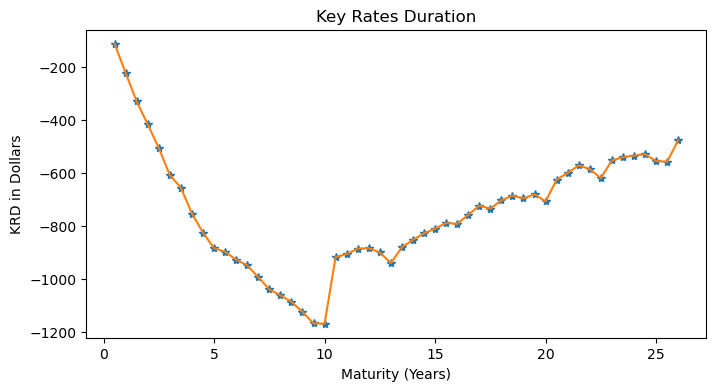

In [166]:
#Plotting
plt.figure(figsize=(8, 4))
plt.plot(maturities, Key_Rate_dur, '*')
plt.plot(maturities, Key_Rate_dur, )
plt.xlabel("Maturity (Years)")
plt.ylabel("KRD in Dollars")
plt.title("Key Rates Duration")
plt.show()

The negative values across
all maturities indicate that an increase in rates at any maturity reduces the portfolio’s value,
which is consistent as the portfolio consists of long bond positions. The KRD curve is smooth
and falls into a narrow range [ -$100; -$1200], suggesting that each maturity contributes
similarly to the overall portfolio interest rate risk. This can be explained by the equal weights
of the portfolio across maturities. Moreover, the U-shape KRD curve shows lower sensitivities
at short and long maturities, with higher sensitivities at intermediate maturities.